### - High MAS (Morphological activity score) and Low TAS (Transcriptional activity score) Compounds i.e. TAS below 0.3 and MAS > 0.7;





- Here, We construct a dataframe of compounds with high MAS in Cell painting and low TAS in L1000 including the landmark genes of these compounds (that are only found in all the compoud's replicates per dose) and the MOAs (Mechanism of actions) of the cpds.

In [1]:
import os
import requests
import pickle
import argparse
import pandas as pd
import numpy as np
import re
from os import walk
from collections import Counter
import random
import shutil
from statistics import median
import math
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")
import pickle
from statistics import median

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [2]:
cp_level4_path = '../cell_painting/cellpainting_lvl4_cpd_replicate_datasets'
L1000_level4_path = '../L1000/L1000_lvl4_cpd_replicate_datasets'

In [3]:
df_cp_pvals = pd.read_csv(os.path.join(cp_level4_path, 'cpd_replicate_p_values.csv'))
df_L1_pvals = pd.read_csv(os.path.join(L1000_level4_path, 'cpd_replicate_p_values.csv'))

In [4]:
df_cp_all = pd.read_csv(os.path.join(cp_level4_path, 'cp_all_scores.csv'))
df_L1_all = pd.read_csv(os.path.join(L1000_level4_path, 'L1000_all_scores.csv'))

In [5]:
with open(os.path.join(cp_level4_path, 'CP_dmso_95_percentile_MAS.pickle'), 'rb') as handle:
    cp_dmso_95pct = pickle.load(handle)
with open(os.path.join(L1000_level4_path, 'L1000_dmso_95_percentile_TAS.pickle'), 'rb') as handle:
    L1_dmso_95pct = pickle.load(handle)

In [6]:
df_lvl4_cp = pd.read_csv(os.path.join(cp_level4_path, 'cp_level4_cpd_replicates.csv.gz'), 
                         compression='gzip',low_memory = False)
df_lvl4_L1000 = pd.read_csv(os.path.join(L1000_level4_path, 'L1000_level4_cpd_replicates.csv.gz'), 
                            compression='gzip',low_memory = False)

In [7]:
def reproducible_dose(df, col_name):
    """
    This function computes how many doses each compound 
    has reproducible median correlation score in, (out of the 6 doses based on p values)
    """
    df_new = df.set_index('cpd').rename_axis(None, axis=0).drop(['cpd_size'], axis = 1).copy()
    cpd_values = {cpd:sum(df_new.loc[cpd] <= 0.05) for cpd in df_new.index}
    df[col_name] = cpd_values.values()
    
    return df

In [8]:
df_cp_pvals = reproducible_dose(df_cp_pvals, 'No_of_reproducible_doses-Cell painting')
df_L1_pvals = reproducible_dose(df_L1_pvals, 'No_of_reproducible_doses-L1000')

In [9]:
df_cp_pvals.head(10)

,cpd,dose_1,dose_2,dose_3,dose_4,dose_5,dose_6,cpd_size,No_of_reproducible_doses-Cell painting
0,10-DEBC,0.340,0.059,0.333,0.420,0.007,0.000,5,2
1,17-hydroxyprogesterone-caproate,0.000,0.012,0.046,0.015,0.015,0.000,5,6
2,2-iminobiotin,0.176,0.072,0.209,0.113,0.422,0.492,5,0
3,2-methoxyestradiol,0.017,0.019,0.000,0.000,0.000,0.000,5,6
4,3-amino-benzamide,0.002,0.018,0.001,0.015,0.000,0.008,5,6
5,3-deazaadenosine,0.290,0.573,0.583,0.908,0.614,0.038,5,1
6,ABT-737,0.038,0.012,0.000,0.001,0.000,0.000,5,6
7,AEE788,0.000,0.019,0.000,0.002,0.000,0.000,5,6
8,AICA-ribonucleotide,0.284,0.543,0.503,0.568,0.387,0.353,2,0
9,AKT-inhibitor-1-2,0.003,0.010,0.001,0.002,0.025,0.007,5,6


In [10]:
def merge_L1000_CP(df_cp,df_L1):
    
    """Merge L1000 and Cell painting dataframes to one, based on the compounds and doses"""
    
    cp_cpd = df_cp['cpd'].unique().tolist()
    L1_cpd = df_L1['cpd'].unique().tolist()
    all_cpds = [x for x in cp_cpd if x in L1_cpd]
    
    df_cp_scores =df_cp.loc[df_cp['cpd'].isin(all_cpds)].reset_index(drop=True)
    df_L1_scores = df_L1.loc[df_L1['cpd'].isin(all_cpds)].reset_index(drop=True)
    df_cp_scores.rename({'replicate_correlation':'median_scores_CP', 
                         'signature_strength':'Cell_painting_SS'}, axis = 1, inplace=True)
    df_L1_scores.rename({'replicate_correlation':'median_scores_L1000', 
                         'signature_strength':'L1000_SS'}, axis = 1, inplace=True)
    df_L1_cp = df_cp_scores.merge(df_L1_scores, on=['cpd', 'dose'])
    
    return df_L1_cp

In [11]:
df_L1_cp_all = merge_L1000_CP(df_cp_all,df_L1_all)

In [12]:
df_L1_cp_all = df_L1_cp_all.merge(df_L1_pvals[['cpd', 'No_of_reproducible_doses-L1000']], on=['cpd'])

In [13]:
df_L1_cp_all = df_L1_cp_all.merge(df_cp_pvals[['cpd', 'No_of_reproducible_doses-Cell painting']], on=['cpd'])

In [14]:
df_L1_cp_all.columns

Index(['cpd', 'dose', 'MAS', 'Cell_painting_SS', 'median_scores_CP', 'TAS',
       'L1000_SS', 'median_scores_L1000', 'No_of_reproducible_doses-L1000',
       'No_of_reproducible_doses-Cell painting'],
      dtype='object')

In [15]:
def plot_mas_vs_tas(df, title, L1_dmso_95pct, cp_dmso_95pct, 
                    hue = 'Cell painting', alp = 0.3, size =(50,300)):
    
    """plot Cell painting MAS (Morphological activity score) vs L1000 TAS (Transcriptional activity score)"""
    
    rel_plt = sns.relplot(data=df, x="MAS", y="TAS", col="dose", hue = 'No_of_reproducible_doses-' + hue, 
                          size = 'No_of_reproducible_doses-' + hue, sizes= size, kind="scatter", 
                          palette=sns.color_palette("Spectral", as_cmap=True),
                          col_wrap=3, height=5.5, aspect=1.3, alpha = alp)
    rel_plt.fig.suptitle(title)
    rel_plt.fig.subplots_adjust(top=.91)
    for idx in range(6):
        rel_plt.axes[idx].axhline(y = L1_dmso_95pct, ls='--', color = 'black', alpha = 0.8, label = '95th-DMSO TAS score')
        rel_plt.axes[idx].axvline(x = cp_dmso_95pct, ls='--', color = 'red', alpha = 0.8, label = '95th-DMSO MAS score')
    leg = rel_plt._legend
    leg.set_bbox_to_anchor([0.90, 0.52])
    plt.legend(bbox_to_anchor=(1.01, 0.505), loc='lower left')
    rel_plt.legend.set_title('Number of\nreproducible\ndoses\n' + '('+ hue +')')
    plt.show()

In [16]:
df_highmas_lowtas = df_L1_cp_all[(df_L1_cp_all['TAS'] < 0.3) & (df_L1_cp_all['MAS'] > 0.7)].reset_index(drop=True).copy()

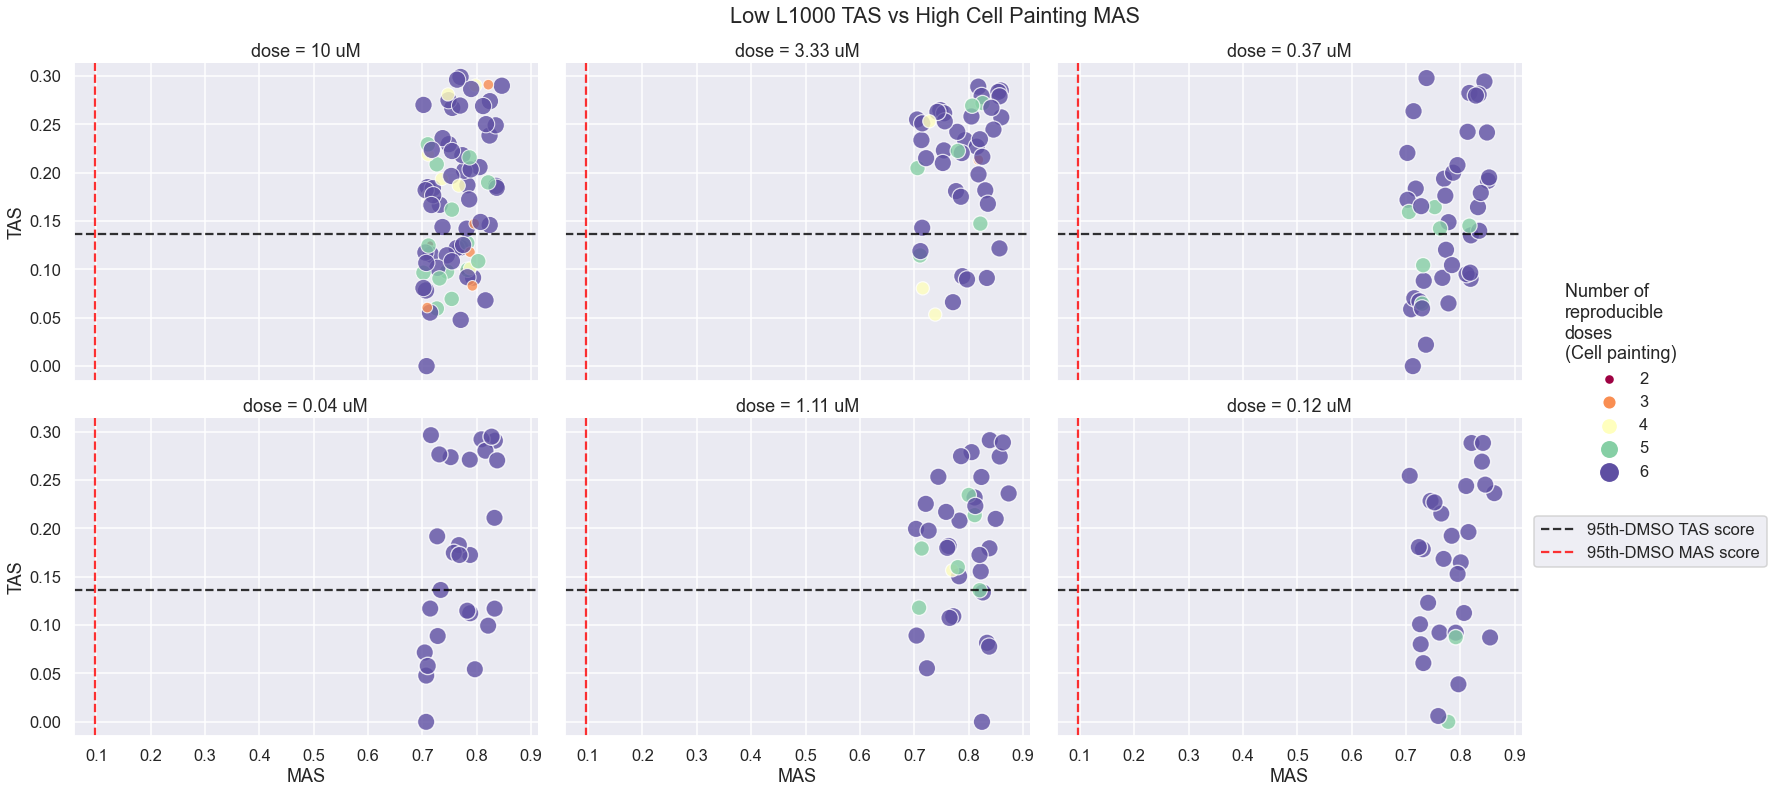

In [17]:
plot_mas_vs_tas(df_highmas_lowtas, "Low L1000 TAS vs High Cell Painting MAS", L1_dmso_95pct, cp_dmso_95pct, alp = 0.8)

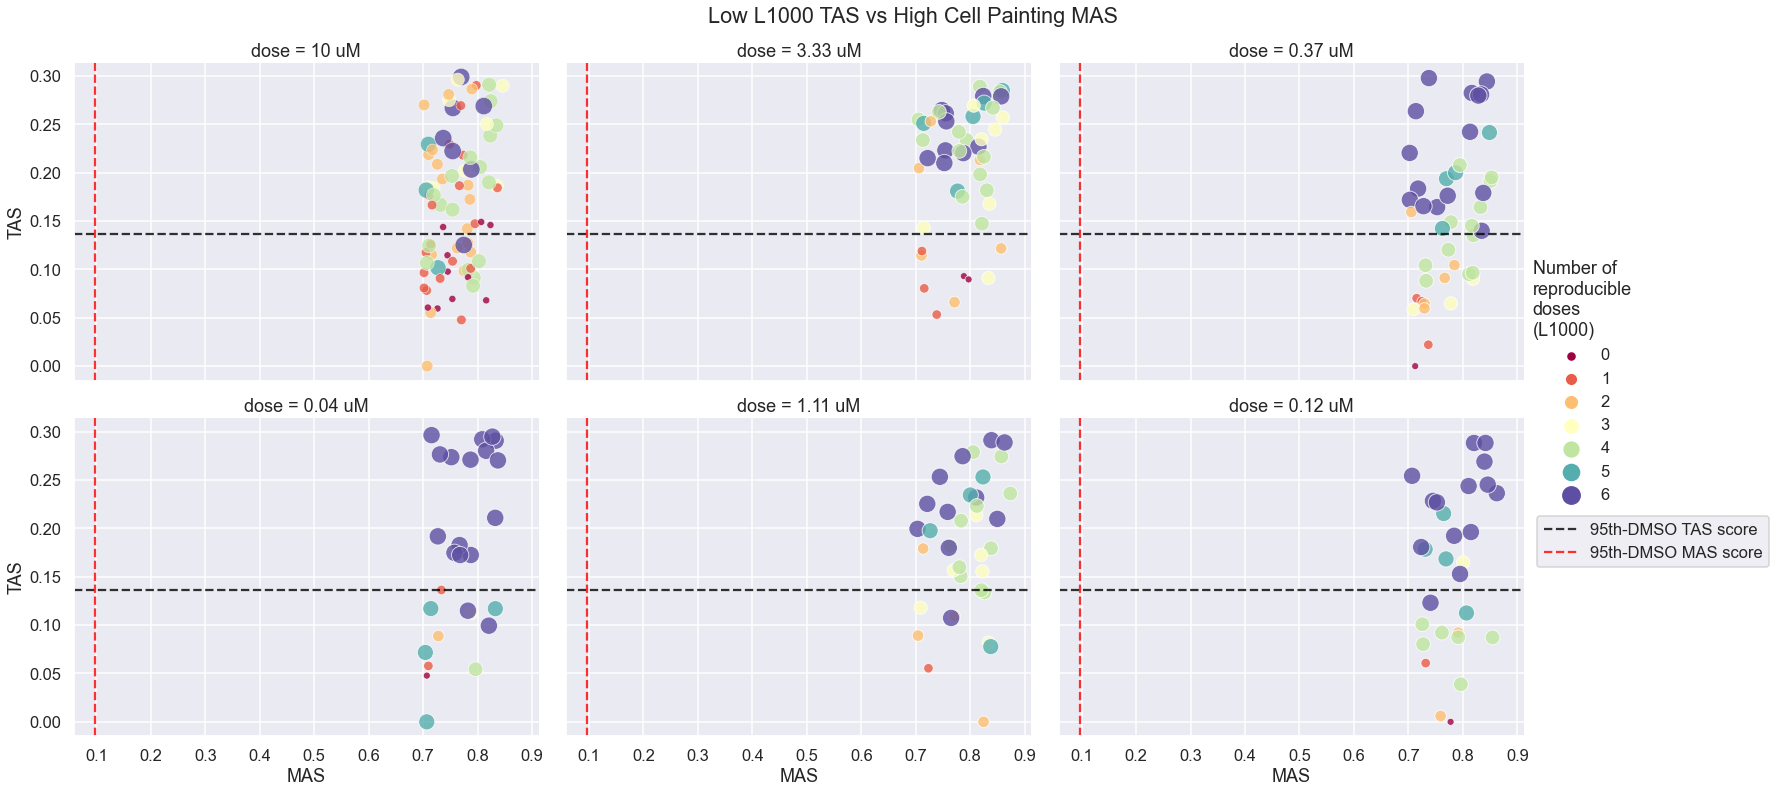

In [18]:
plot_mas_vs_tas(df_highmas_lowtas, "Low L1000 TAS vs High Cell Painting MAS", 
                L1_dmso_95pct, cp_dmso_95pct, hue = 'L1000', alp = 0.8)

In [19]:
df_highmas_lowtas.shape

(264, 10)

In [20]:
df_lvl4_L1000['dose'].unique()

array([0, 6, 5, 4, 3, 2, 1, 7], dtype=int64)

In [21]:
df_highmas_lowtas['dose'] = df_highmas_lowtas['dose'].map({'0.04 uM' : 1, '0.12 uM' : 2, '0.37 uM' : 3, 
                                                           '1.11 uM' : 4, '3.33 uM' : 5, '10 uM' : 6})

In [22]:
df_highmas_lowtas['dose'].unique()

array([6, 5, 3, 1, 4, 2], dtype=int64)

In [23]:
def get_cpd_gene_per_dose(df_mas_tas, df_lvl4):
    
    """
    This function returns landmark genes of COMPOUNDS with high MAS but low TAS score per dose 
    that are present in all the compound replicates
    """
    cpd_gene_dict = {}
    for cpd in df_mas_tas['cpd'].unique():
        df_cpd = df_lvl4[df_lvl4['pert_iname'] == cpd].copy()
        cpd_mas_tas = df_mas_tas[df_mas_tas['cpd'] == cpd]
        for dose in cpd_mas_tas['dose'].unique():
            genes_per_dose = {}
            df_cpd_dose = df_cpd[df_cpd['dose'] == dose].copy()
            df_cpd_dose.drop(['replicate_id', 'Metadata_broad_sample', 'pert_id', 'dose', 'pert_idose', 
                              'pert_iname', 'moa', 'det_plate', 'det_well', 'sig_id'], axis = 1, inplace = True)
            df_cpd_reps = abs(df_cpd_dose.T)
            genes_gtr_2 = df_cpd_reps[df_cpd_reps >= 2.0].stack().index.tolist()
            genes_list = [gene for gene,feat in genes_gtr_2]
            genes_list = [key for key in dict(Counter(genes_list)) if dict(Counter(genes_list))[key] \
                          == len(df_cpd_reps.columns)]
            genes_per_dose[dose] = genes_list
            if cpd not in cpd_gene_dict:
                cpd_gene_dict[cpd] = genes_per_dose
            else:
                cpd_gene_dict[cpd][dose] = genes_list
    return cpd_gene_dict

In [24]:
cpds_dict = get_cpd_gene_per_dose(df_highmas_lowtas, df_lvl4_L1000)

In [25]:
pertinfo_file = '../aligned_moa_CP_L1000.csv'
df_pertinfo = pd.read_csv(pertinfo_file)
df_pertinfo.rename(columns={"pert_iname": "cpd"}, inplace = True)

In [26]:
def get_highmas_lowtas_df(cpd_dict, df_mas_tas, df_pertinfo):
    
    """
    This function return a dataframe of compounds with high MAS and low TAS, 
    including their landmark genes that show high signature strength 
    in all cpds replicates per dose, and the cpd's MOAs
    """
    df = pd.DataFrame(columns = ['cpd', 'dose', 'landmark_genes'])
    for keys in cpd_dict:
        for sub in cpd_dict[keys]:
            for vals in cpd_dict[keys][sub]:
                df = df.append({'cpd': keys, 'dose': sub, 'landmark_genes': vals}, ignore_index=True)            
    df = df.merge(df_pertinfo[['cpd', 'moa']], on=['cpd'])
    df = df.merge(df_mas_tas[['cpd', 'dose', 'MAS', 'TAS']], on=['cpd', 'dose'])
    return df

In [27]:
df_cpds_highmas_lowtas = get_highmas_lowtas_df(cpds_dict, df_highmas_lowtas, df_pertinfo)

In [28]:
df_cpds_highmas_lowtas

,cpd,dose,landmark_genes,moa,MAS,TAS
0,17-hydroxyprogesterone-caproate,6,205039_s_at,Progesterone receptor agonist,0.709677,0.185120
1,17-hydroxyprogesterone-caproate,6,207515_s_at,Progesterone receptor agonist,0.709677,0.185120
2,17-hydroxyprogesterone-caproate,6,208763_s_at,Progesterone receptor agonist,0.709677,0.185120
3,17-hydroxyprogesterone-caproate,6,201761_at,Progesterone receptor agonist,0.709677,0.185120
4,17-hydroxyprogesterone-caproate,6,201000_at,Progesterone receptor agonist,0.709677,0.185120
...,...,...,...,...,...,...
5021,ziprasidone,6,218375_at,Dopamine receptor antagonist|Serotonin recepto...,0.701835,0.080795
5022,ziprasidone,6,221750_at,Dopamine receptor antagonist|Serotonin recepto...,0.701835,0.080795
5023,ziprasidone,6,217989_at,Dopamine receptor antagonist|Serotonin recepto...,0.701835,0.080795
5024,ziprasidone,6,203973_s_at,Dopamine receptor antagonist|Serotonin recepto...,0.701835,0.080795


In [29]:
def save_to_csv(df, path, file_name, compress=None):
    """saves dataframes to csv"""
    if not os.path.exists(path):
        os.mkdir(path)
    df.to_csv(os.path.join(path, file_name), index=False, compression=compress)

In [30]:
save_to_csv(df_cpds_highmas_lowtas, L1000_level4_path, 'cpds_highmas_lowtas.csv')